In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
import shap
shap.initjs()

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_init = pd.read_csv('data.csv', sep=';')
df_init.head()

,Id,Result,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_109,Feature_110,Feature_111,Feature_112,Feature_113,Feature_114,Feature_115,Feature_116,Feature_117,Feature_118
0,1,2,2,56,12,1,7.0,4,0,1.0,...,1.0,0.0,1,0,1,1,1,1,1,0
1,2,2,2,69,19,1,6.0,4,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,1
2,3,2,1,66,8,1,4.0,4,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,0
3,4,2,2,62,16,1,NaN,3,0,1.0,...,1.0,0.0,1,0,1,1,0,0,1,1
4,5,2,2,67,30,1,NaN,4,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,0


In [3]:
def train(df, trash_features = []):

    df_ = df.copy()

    target_feature = 'Result'

    usefull_features = []

    useless_features = ['Id', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_17', 'Feature_18', 'Feature_23', 
                        'Feature_29', 'Feature_30', 'Feature_32','Feature_33', 'Feature_34',
                        'Feature_35', 'Feature_54', 'Feature_94', 'Feature_101', 'Feature_108','Feature_111', 
                        'Feature_112','Feature_113', 'Feature_114','Feature_115', 'Feature_116', 'Feature_117']
    
    features_to_drop = [target_feature] + useless_features
    for feature in trash_features:
        if feature not in usefull_features and feature not in useless_features:
            features_to_drop.append(feature)

    all_features = df_.columns.drop(features_to_drop).tolist()

    df_ = df_[[target_feature] + all_features]

    num_features = ['Feature_3', 'Feature_39', 'Feature_40', 'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 
                    'Feature_45', 'Feature_46', 'Feature_47', 'Feature_48', 'Feature_49', 'Feature_50', 'Feature_51', 
                    'Feature_53', 'Feature_55', 'Feature_57', 'Feature_58', 'Feature_59', 'Feature_64', 'Feature_70', 
                    'Feature_71', 'Feature_72', 'Feature_73']
    
    special_features = ['Feature_17', 'Feature_18', 'Feature_23', 'Feature_74', 'Feature_75', 'Feature_76', 'Feature_77', 
                        'Feature_78', 'Feature_79', 'Feature_80', 'Feature_81', 'Feature_82', 'Feature_83', 'Feature_84', 
                        'Feature_85', 'Feature_86', 'Feature_87', 'Feature_88', 'Feature_89', 'Feature_90', 'Feature_91', 
                        'Feature_92', 'Feature_93', 'Feature_94', 'Feature_95', 'Feature_96', 'Feature_97', 'Feature_98', 
                        'Feature_99', 'Feature_100']
    
    for col in special_features:
        if col in df_.columns:
            df_[col].fillna(0, inplace=True)

    cat_features = []
    for col in df_.drop(target_feature, axis=1).columns:
        if col in num_features:
            df_[col].fillna(df_[col].median(), inplace=True)
            df_[col] = df_[col].astype('float64')
        else:
            cat_features.append(col)

            df_[col].fillna(-1, inplace=True)
            df_[col] = df_[col].astype('int64')
    
    # Result=0 - alive, Result=1 died
    df_.loc[df_[target_feature] == 1, target_feature] = 0
    df_.loc[df_[target_feature] == 2, target_feature] = 1

    X = df_[all_features]
    y = df_[target_feature]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        shuffle=True,
        test_size=0.25,
        random_state=0,
        stratify=y,
    )

    train_pool = Pool(
        X_train,
        y_train,
        cat_features=cat_features
    )

    params_frozen = {
        'eval_metric': 'Accuracy',
        'early_stopping_rounds': 50,
    }

    params_grid = {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.03, 0.1, 0.3, 0.5],
        'iterations': [100, 200, 400, 600, 800, 1000, 1200],
        'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
        'bagging_temperature': [1, 1.5, 2, 2.5],
    }

    clf = CatBoostClassifier(**params_frozen)
    rs = clf.randomized_search(
        params_grid,
        train_pool,
        n_iter=5,
        shuffle=True,
        stratified=True,
        partition_random_seed=0,
        cv=5,
        calc_cv_statistics=True,
        search_by_train_test_split=False,
        refit=True,
    )

    return clf, df_, X_train, X_test, y_train, y_test, all_features, cat_features, target_feature

In [4]:
trash_features = []
epochs = 5
for epoch in range(1, epochs+1):

    print(f"\nEpoch {epoch} from {epochs}\n{'=' * 50}")

    clf, df, X_train, X_test, y_train, y_test, all_features, cat_features, target_feature = train(
        df_init,
        trash_features=trash_features,
    )

    test_pool = Pool(
        X_test,
        y_test,
        cat_features=cat_features
    )
    y_test_pred = clf.predict(test_pool)

    print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
    print(f'F1 Score: {round(f1_score(y_test, y_test_pred), 2)}')
    print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')

    feature_importances = pd.DataFrame(
        zip(X_train.columns, clf.get_feature_importance()),
        columns=['feature_name', 'importance']
    )

    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    features = feature_importances[feature_importances['importance'] < 1 ]['feature_name'].tolist()
    if len(trash_features) > 0:
        for feature in features:
            if feature not in trash_features:
                trash_features.append(feature)
    else:
        trash_features=features

    print('Fetures to drop')
    print(trash_features)


Epoch 1 from 5
Stopped by overfitting detector  (50 iterations wait)
0:	loss: 0.6901732	best: 0.6901732 (0)	total: 22s	remaining: 1m 27s
Stopped by overfitting detector  (50 iterations wait)
1:	loss: 0.7542424	best: 0.7542424 (1)	total: 1m 11s	remaining: 1m 47s
Stopped by overfitting detector  (50 iterations wait)
2:	loss: 0.7446753	best: 0.7542424 (1)	total: 1m 34s	remaining: 1m 2s
Stopped by overfitting detector  (50 iterations wait)
3:	loss: 0.7265368	best: 0.7542424 (1)	total: 2m 53s	remaining: 43.3s
Stopped by overfitting detector  (50 iterations wait)
4:	loss: 0.7637662	best: 0.7637662 (4)	total: 3m 53s	remaining: 0us
Accuracy: 0.69
F1 Score: 0.79

Classification report: 
              precision    recall  f1-score   support

           0       0.50      0.36      0.42        11
           1       0.75      0.84      0.79        25

    accuracy                           0.69        36
   macro avg       0.62      0.60      0.61        36
weighted avg       0.67      0.69      0

In [5]:
feature_importances = pd.DataFrame(
    zip(X_train.columns, clf.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

for feature in feature_importances[15:]['feature_name'].tolist():
    if feature not in trash_features:
        trash_features.append(feature)

In [6]:
clf, df, X_train, X_test, y_train, y_test, all_features, cat_features, target_feature = train(
    df_init,
    trash_features=trash_features,
)

test_pool = Pool(
    X_test,
    y_test,
    cat_features=cat_features
)
y_test_pred = clf.predict(test_pool)
y_test_pred_proba = clf.predict_proba(test_pool)

print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
print(f'F1 Score: {round(f1_score(y_test, y_test_pred), 2)}')
print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')

Stopped by overfitting detector  (50 iterations wait)
0:	loss: 0.7724242	best: 0.7724242 (0)	total: 24.9s	remaining: 1m 39s
Stopped by overfitting detector  (50 iterations wait)
1:	loss: 0.7924242	best: 0.7924242 (1)	total: 40.1s	remaining: 1m
Stopped by overfitting detector  (50 iterations wait)
2:	loss: 0.7633766	best: 0.7924242 (1)	total: 51.9s	remaining: 34.6s
Stopped by overfitting detector  (50 iterations wait)
3:	loss: 0.7742424	best: 0.7924242 (1)	total: 1m 20s	remaining: 20.2s
Stopped by overfitting detector  (50 iterations wait)
4:	loss: 0.7833333	best: 0.7924242 (1)	total: 1m 50s	remaining: 0us
Accuracy: 0.86
F1 Score: 0.9

Classification report: 
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.92      0.88      0.90        25

    accuracy                           0.86        36
   macro avg       0.83      0.85      0.84        36
weighted avg       0.87      0.86      0.86        36



In [7]:
feature_importances = pd.DataFrame(
    zip(X_train.columns, clf.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(50)

,feature_name,importance
8,Feature_56,13.352458
2,Feature_41,12.853967
1,Feature_28,9.473234
12,Feature_70,9.196992
14,Feature_99,9.025257
0,Feature_6,8.224454
6,Feature_49,7.209991
5,Feature_47,6.785851
13,Feature_71,4.852039
4,Feature_46,4.081496


In [8]:
explainer = shap.TreeExplainer(clf)
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

## Важность признаков при оценке через числа Шепли

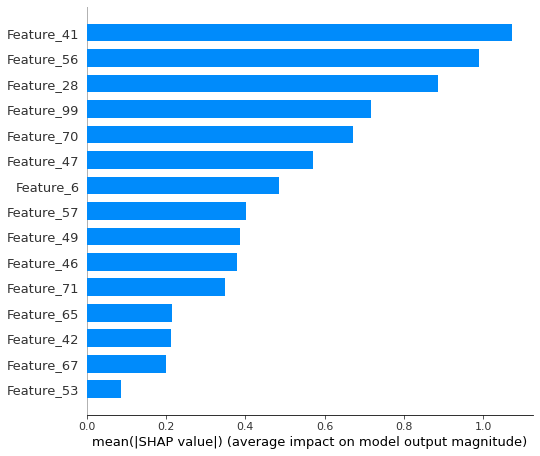

In [10]:
shap.summary_plot(shap_values_train, X_train, plot_type="bar", max_display=40)

## Число Шепли / Признаки

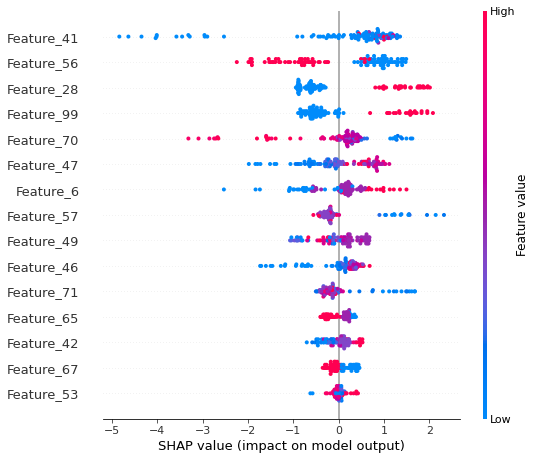

In [9]:
shap.summary_plot(shap_values_train, X_train, max_display=40)

## Тестовый датасет

### Добавленные колонки

* Result_true	- исход в исходных данных
* Result_pred	 - исход предсказанный
* Result_pred_proba - вероятность, с которой предсказан первый класс

In [11]:
df_explain_table = X_test.copy()
df_explain = X_test.copy()

df_explain_table['Result_true'] = y_test
df_explain_table['Result_pred'] = y_test_pred
df_explain_table['Result_pred_proba'] = y_test_pred_proba[:, 1:2]

## Наблюдения из тестового датасета, на которых модель ошибается

In [12]:
df_errors = df_explain_table[df_explain_table['Result_true'] != df_explain_table['Result_pred']]
df_errors.T

,4,53,134,140,35
Feature_6,4.000000,3.0000,2.000000,2.000000,2.000000
Feature_28,0.000000,0.0000,0.000000,0.000000,0.000000
Feature_41,0.007000,0.0600,0.060000,0.060000,0.020000
Feature_42,530.000000,1021.0000,804.300000,804.300000,1302.500000
Feature_46,66.400000,220.3800,85.550000,60.060000,81.840000
Feature_47,5.000000,20.2000,4.400000,7.700000,2.600000
Feature_49,4.100000,4.0000,4.000000,4.000000,4.000000
Feature_53,70.000000,80.0000,32.000000,40.000000,85.000000
Feature_56,0.000000,1.0000,-1.000000,-1.000000,-1.000000
Feature_57,38.000000,47.0000,38.000000,38.000000,38.000000


### в исходной таблице #5, #54, #135, #141, #36